Partially from https://towardsdatascience.com/step-by-step-understanding-lstm-autoencoder-layers-ffab055b6352

Learning LSTM Autoencoder and LSTM Network on a simple Multivariate Timeseries Toy example

In [1]:
# lstm autoencoder to recreate a timeseries
import numpy as np
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import RepeatVector
from keras.layers import TimeDistributed
import pandas as pd

#### Prepocessing times series data

In [2]:
'''
A UDF to convert input data into 3-D
array as required for LSTM network.
'''

def temporalize(X, y, lookback):
    output_X = []
    output_y = []
    for i in range(len(X)-lookback-1):
        t = []
        for j in range(1,lookback+1):
            # Gather past records upto the lookback period
            t.append( X[[(i+j+1)], :])
        output_X.append(t)
        output_y.append(y[i+lookback+1])
    return output_X, output_y

#### make toy example

In [6]:
# define input timeseries
timeseries = np.array([[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
                       [0.1**3, 0.2**3, 0.3**3, 0.4**3, 0.5**3, 0.6**3, 0.7**3, 0.8**3, 0.9**3]]).transpose()

timesteps = timeseries.shape[0]
n_features = timeseries.shape[1]
timeseries

array([[0.1  , 0.001],
       [0.2  , 0.008],
       [0.3  , 0.027],
       [0.4  , 0.064],
       [0.5  , 0.125],
       [0.6  , 0.216],
       [0.7  , 0.343],
       [0.8  , 0.512],
       [0.9  , 0.729]])

In [18]:
# print(timeseries[ 3 , : ])
# print( )

[0.4   0.064]
[[0.4   0.064]]


In [23]:
timesteps = 3
X, y = temporalize(X = timeseries, y = np.zeros(len(timeseries)), lookback = timesteps)

n_features = 2
X = np.array(X)
X = X.reshape(X.shape[0], timesteps, n_features)

X # Input data converted into 3D array of (n_samples, timesteps, n_features) 

array([[[0.3  , 0.027],
        [0.4  , 0.064],
        [0.5  , 0.125]],

       [[0.4  , 0.064],
        [0.5  , 0.125],
        [0.6  , 0.216]],

       [[0.5  , 0.125],
        [0.6  , 0.216],
        [0.7  , 0.343]],

       [[0.6  , 0.216],
        [0.7  , 0.343],
        [0.8  , 0.512]],

       [[0.7  , 0.343],
        [0.8  , 0.512],
        [0.9  , 0.729]]])

![lstm](./figure/LSTM.png)

![lstm](./figure/LSTM2.png)

In [25]:
# define model
model = Sequential()
model.add(LSTM(128, activation='relu', input_shape=(timesteps,n_features), return_sequences=True))
model.add(LSTM(64, activation='relu', return_sequences=False))
model.add(RepeatVector(timesteps))
model.add(LSTM(64, activation='relu', return_sequences=True))
model.add(LSTM(128, activation='relu', return_sequences=True))
model.add(TimeDistributed(Dense(n_features)))
model.compile(optimizer='adam', loss='mse')
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_4 (LSTM)               (None, 3, 128)            67072     
                                                                 
 lstm_5 (LSTM)               (None, 64)                49408     
                                                                 
 repeat_vector_1 (RepeatVect  (None, 3, 64)            0         
 or)                                                             
                                                                 
 lstm_6 (LSTM)               (None, 3, 64)             33024     
                                                                 
 lstm_7 (LSTM)               (None, 3, 128)            98816     
                                                                 
 time_distributed_1 (TimeDis  (None, 3, 2)             258       
 tributed)                                            

In [26]:
# fit model
model.fit(X, X, epochs=300, batch_size=5, verbose=0)
# demonstrate reconstruction
yhat = model.predict(X, verbose=0)
print('---Predicted---')
print(np.round(yhat,3))
print('---Actual---')
print(np.round(X, 3))

---Predicted---
[[[0.314 0.036]
  [0.412 0.065]
  [0.494 0.119]]

 [[0.387 0.065]
  [0.502 0.127]
  [0.595 0.212]]

 [[0.493 0.12 ]
  [0.601 0.221]
  [0.704 0.345]]

 [[0.604 0.203]
  [0.695 0.345]
  [0.805 0.513]]

 [[0.7   0.348]
  [0.803 0.509]
  [0.9   0.728]]]
---Actual---
[[[0.3   0.027]
  [0.4   0.064]
  [0.5   0.125]]

 [[0.4   0.064]
  [0.5   0.125]
  [0.6   0.216]]

 [[0.5   0.125]
  [0.6   0.216]
  [0.7   0.343]]

 [[0.6   0.216]
  [0.7   0.343]
  [0.8   0.512]]

 [[0.7   0.343]
  [0.8   0.512]
  [0.9   0.729]]]


#### Another Model

![LSTM3](./figure/LSTM3.png)

In [27]:
# define model
model = Sequential()
model.add(LSTM(128, activation='relu', input_shape=(timesteps,n_features), return_sequences=True))
model.add(LSTM(64, activation='relu', return_sequences=True))
model.add(LSTM(64, activation='relu', return_sequences=True))
model.add(LSTM(128, activation='relu', return_sequences=True))
model.add(TimeDistributed(Dense(n_features)))
model.compile(optimizer='adam', loss='mse')

from keras.callbacks import ModelCheckpoint, TensorBoard
cp = ModelCheckpoint(filepath="autoencoder_classifier.h5",
                               save_best_only=True,
                               verbose=0)
tb = TensorBoard(log_dir='./logs',
                histogram_freq=0,
                write_graph=True,
                write_images=True)
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_8 (LSTM)               (None, 3, 128)            67072     
                                                                 
 lstm_9 (LSTM)               (None, 3, 64)             49408     
                                                                 
 lstm_10 (LSTM)              (None, 3, 64)             33024     
                                                                 
 lstm_11 (LSTM)              (None, 3, 128)            98816     
                                                                 
 time_distributed_2 (TimeDis  (None, 3, 2)             258       
 tributed)                                                       
                                                                 
Total params: 248,578
Trainable params: 248,578
Non-trainable params: 0
________________________________________________

In [ ]:
# fit model
history = model.fit(X, X, epochs=300, batch_size=5, verbose=1,callbacks=[cp, tb]).history

In [29]:
# demonstrate reconstruction
yhat = model.predict(X, verbose=0)
print('---Predicted---')
print(np.round(yhat,3))
print('---Actual---')
print(np.round(X, 3))

---Predicted---
[[[0.34  0.066]
  [0.401 0.047]
  [0.502 0.125]]

 [[0.398 0.094]
  [0.497 0.115]
  [0.603 0.226]]

 [[0.475 0.141]
  [0.594 0.206]
  [0.699 0.349]]

 [[0.585 0.214]
  [0.705 0.341]
  [0.796 0.514]]

 [[0.715 0.307]
  [0.8   0.522]
  [0.906 0.728]]]
---Actual---
[[[0.3   0.027]
  [0.4   0.064]
  [0.5   0.125]]

 [[0.4   0.064]
  [0.5   0.125]
  [0.6   0.216]]

 [[0.5   0.125]
  [0.6   0.216]
  [0.7   0.343]]

 [[0.6   0.216]
  [0.7   0.343]
  [0.8   0.512]]

 [[0.7   0.343]
  [0.8   0.512]
  [0.9   0.729]]]


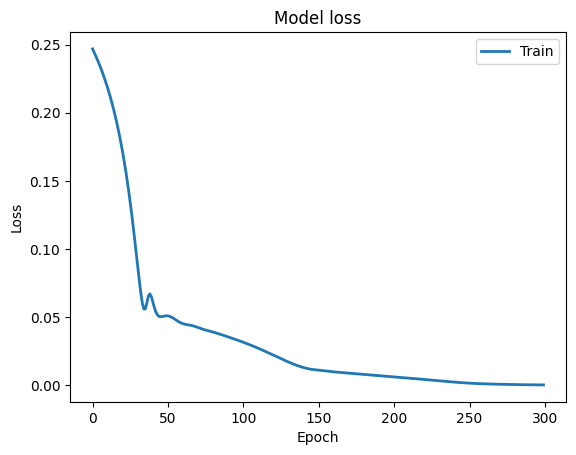

In [30]:
import matplotlib.pyplot as plt

plt.plot(history['loss'], linewidth=2, label='Train')

plt.legend(loc='upper right')
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.show()

### Finance Data

In [31]:
"""
@author: Sreenivas Bhattiprolu
Shows errors on Tensorflow 1.4 and Keras 2.0.8
Works fine in Tensorflow: 2.2.0
    Keras: 2.4.3
dataset: https://finance.yahoo.com/quote/GE/history/
Also try S&P: https://finance.yahoo.com/quote/%5EGSPC/history?p=%5EGSPC
"""

import numpy as np
from keras.models import Sequential
from keras.layers import LSTM, Input, Dropout
from keras.layers import Dense
from keras.layers import RepeatVector
from keras.layers import TimeDistributed
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from keras.models import Model
import seaborn as sns


In [37]:
dataframe = pd.read_csv('/content/GE.csv')
# dataframe.

In [39]:
dataframe

,Date,Open,High,Low,Close,Adj Close,Volume
0,1962-01-02,4.691347,4.769536,4.644433,4.675709,0.785728,345317
1,1962-01-03,4.652252,4.652252,4.613158,4.628796,0.777844,236606
2,1962-01-04,4.628796,4.667890,4.534969,4.574063,0.768646,294159
3,1962-01-05,4.574063,4.581882,4.378590,4.456780,0.748938,436442
4,1962-01-08,4.456780,4.456780,4.316039,4.448961,0.747624,495593
...,...,...,...,...,...,...,...
15427,2023-04-17,95.620003,96.849998,95.480003,96.769997,96.769997,6126100
15428,2023-04-18,97.000000,98.519997,96.860001,98.470001,98.470001,7110800
15429,2023-04-19,98.580002,99.309998,98.419998,99.029999,99.029999,5617000
15430,2023-04-20,99.300003,100.470001,99.059998,99.760002,99.760002,6912400


In [42]:
type(dataframe['Date'][0])

str

In [38]:
df = dataframe[['Date', 'Close']]
df['Date'] = pd.to_datetime(df['Date'])

<ipython-input-38-58780e2957dd>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Date'] = pd.to_datetime(df['Date'])


In [43]:
type(df['Date'][0])

pandas._libs.tslibs.timestamps.Timestamp

In [46]:
df['Date'][0].date()

datetime.date(1962, 1, 2)

Start date is:  1962-01-02 00:00:00
End date is:  2023-04-21 00:00:00


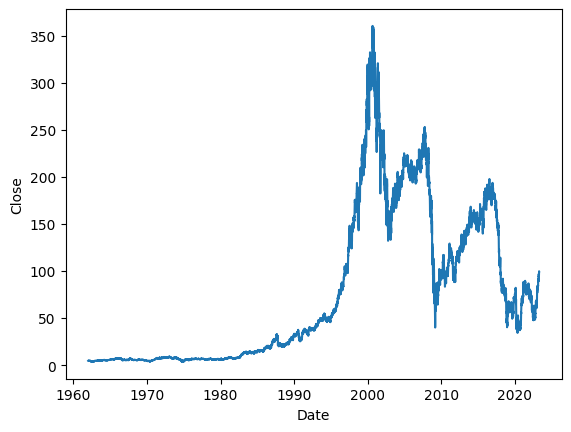

In [50]:
sns.lineplot(x=df['Date'], y=df['Close'])

print("Start date is: ", df['Date'].min())
print("End date is: ", df['Date'].max())

#Change train data from Mid 2017 to 2019.... seems to be a jump early 2017
train, test = df.loc[df['Date'] <= '2017-12-31'], df.loc[df['Date'] > '2017-12-31']

In [52]:
print( len(train), len(test) )

14097 1335


In [53]:
#Convert pandas dataframe to numpy array
#dataset = dataframe.values
#dataset = dataset.astype('float32') #COnvert values to float

#LSTM uses sigmoid and tanh that are sensitive to magnitude so values need to be normalized
# normalize the dataset
#scaler = MinMaxScaler() #Also try QuantileTransformer
scaler = StandardScaler()
scaler = scaler.fit(train[['Close']])

train['Close'] = scaler.transform(train[['Close']])
test['Close'] = scaler.transform(test[['Close']])

<ipython-input-53-61dbea5b77ab>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['Close'] = scaler.transform(train[['Close']])
<ipython-input-53-61dbea5b77ab>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['Close'] = scaler.transform(test[['Close']])


In [54]:
#As required for LSTM networks, we require to reshape an input data into n_samples x timesteps x n_features. 
#In this example, the n_features is 2. We will make timesteps = 3. 
#With this, the resultant n_samples is 5 (as the input data has 9 rows).

seq_size = 30  # Number of time steps to look back 
#Larger sequences (look further back) may improve forecasting.


def to_sequences(x, y, seq_size=1):
    x_values = []
    y_values = []

    for i in range(len(x)-seq_size):
        #print(i)
        x_values.append(x.iloc[i:(i+seq_size)].values)
        y_values.append(y.iloc[i+seq_size])
        
    return np.array(x_values), np.array(y_values)

trainX, trainY = to_sequences(train[['Close']], train['Close'], seq_size)
testX, testY = to_sequences(test[['Close']], test['Close'], seq_size)

In [55]:
print(trainX)

[[[-0.84535562]
  [-0.84590733]
  [-0.84655102]
  ...
  [-0.84480388]
  [-0.84507975]
  [-0.84507975]]

 [[-0.84590733]
  [-0.84655102]
  [-0.84793033]
  ...
  [-0.84507975]
  [-0.84507975]
  [-0.84443607]]

 [[-0.84655102]
  [-0.84793033]
  [-0.84802228]
  ...
  [-0.84507975]
  [-0.84443607]
  [-0.8439763 ]]

 ...

 [[ 0.44286401]
  [ 0.36376864]
  [ 0.38919216]
  ...
  [ 0.33340171]
  [ 0.3355204 ]
  [ 0.33057689]]

 [[ 0.36376864]
  [ 0.38919216]
  [ 0.38848602]
  ...
  [ 0.3355204 ]
  [ 0.33057689]
  [ 0.32704584]]

 [[ 0.38919216]
  [ 0.38848602]
  [ 0.38566119]
  ...
  [ 0.33057689]
  [ 0.32704584]
  [ 0.32563346]]]


In [56]:

# define Autoencoder model
#Input shape would be seq_size, 1 - 1 beacuse we have 1 feature. 
# seq_size = trainX.shape[1]

# model = Sequential()
# model.add(LSTM(128, activation='relu', input_shape=(trainX.shape[1], trainX.shape[2]), return_sequences=True))
# model.add(LSTM(64, activation='relu', return_sequences=False))
# model.add(RepeatVector(trainX.shape[1]))
# model.add(LSTM(64, activation='relu', return_sequences=True))
# model.add(LSTM(128, activation='relu', return_sequences=True))
# model.add(TimeDistributed(Dense(trainX.shape[2])))

# model.compile(optimizer='adam', loss='mse')
# model.summary()

#Try another model
model = Sequential()
model.add(LSTM(128, input_shape=(trainX.shape[1], trainX.shape[2])))
model.add(Dropout(rate=0.2))

model.add(RepeatVector(trainX.shape[1]))

model.add(LSTM(128, return_sequences=True))
model.add(Dropout(rate=0.2))
model.add(TimeDistributed(Dense(trainX.shape[2])))
model.compile(optimizer='adam', loss='mae')
model.summary()


Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_12 (LSTM)              (None, 128)               66560     
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 repeat_vector_2 (RepeatVect  (None, 30, 128)          0         
 or)                                                             
                                                                 
 lstm_13 (LSTM)              (None, 30, 128)           131584    
                                                                 
 dropout_1 (Dropout)         (None, 30, 128)           0         
                                                                 
 time_distributed_3 (TimeDis  (None, 30, 1)            129       
 tributed)                                            

Epoch 1/10
396/396 [==============================] - 50s 115ms/step - loss: 0.7155 - val_loss: 1.6166
Epoch 2/10
396/396 [==============================] - 50s 128ms/step - loss: 0.7072 - val_loss: 1.5907
Epoch 3/10
396/396 [==============================] - 46s 117ms/step - loss: 0.7067 - val_loss: 1.5702
Epoch 4/10
396/396 [==============================] - 52s 133ms/step - loss: 0.7058 - val_loss: 1.5409
Epoch 5/10
396/396 [==============================] - 44s 112ms/step - loss: 0.7057 - val_loss: 1.5790
Epoch 6/10
396/396 [==============================] - 43s 108ms/step - loss: 0.7057 - val_loss: 1.5288
Epoch 7/10
396/396 [==============================] - 48s 121ms/step - loss: 0.7057 - val_loss: 1.5673
Epoch 8/10
396/396 [==============================] - 43s 107ms/step - loss: 0.7054 - val_loss: 1.5195
Epoch 9/10
396/396 [==============================] - 43s 108ms/step - loss: 0.7059 - val_loss: 1.5598
Epoch 10/10
41/41 [==============================] - 1s 30ms/step


(array([ 65.,  53.,  41.,  17.,  13.,  22.,  41.,  65.,  51.,  52.,  74.,
         67.,  61.,  27.,  51.,  53.,  42.,  96.,  44.,  36., 148., 100.,
         31.,  21.,  10.,  11.,   5.,   2.,   3.,   3.]),
 array([0.2388484 , 0.26214151, 0.28543462, 0.30872772, 0.33202083,
        0.35531394, 0.37860705, 0.40190015, 0.42519326, 0.44848637,
        0.47177947, 0.49507258, 0.51836569, 0.5416588 , 0.5649519 ,
        0.58824501, 0.61153812, 0.63483122, 0.65812433, 0.68141744,
        0.70471055, 0.72800365, 0.75129676, 0.77458987, 0.79788297,
        0.82117608, 0.84446919, 0.8677623 , 0.8910554 , 0.91434851,
        0.93764162]),
 <BarContainer object of 30 artists>)

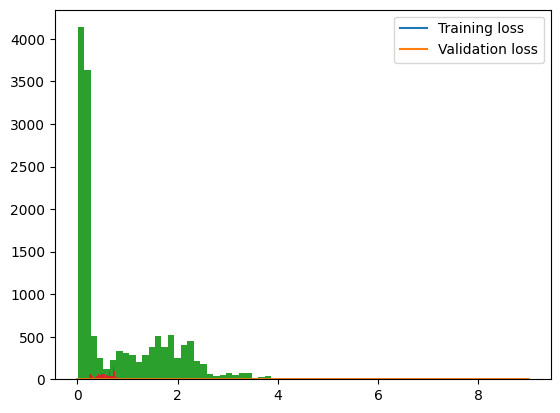

In [57]:
# fit model
history = model.fit(trainX, trainY, epochs=10, batch_size=32, validation_split=0.1, verbose=1)

plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.legend()

#model.evaluate(testX, testY)

###########################
#Anomaly is where reconstruction error is large.
#We can define this value beyond which we call anomaly.
#Let us look at MAE in training prediction

trainPredict = model.predict(trainX)
trainMAE = np.mean(np.abs(trainPredict - trainX), axis=1)
plt.hist(trainMAE, bins=30)
max_trainMAE = 0.3  #or Define 90% value of max as threshold.

testPredict = model.predict(testX)
testMAE = np.mean(np.abs(testPredict - testX), axis=1)
plt.hist(testMAE, bins=30)


<Axes: xlabel='Date', ylabel='testMAE'>

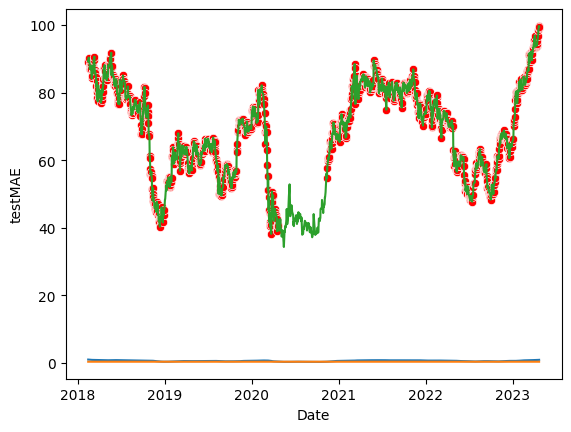

In [58]:

#Capture all details in a DataFrame for easy plotting
anomaly_df = pd.DataFrame(test[seq_size:])
anomaly_df['testMAE'] = testMAE
anomaly_df['max_trainMAE'] = max_trainMAE
anomaly_df['anomaly'] = anomaly_df['testMAE'] > anomaly_df['max_trainMAE']
anomaly_df['Close'] = test[seq_size:]['Close']

#Plot testMAE vs max_trainMAE
sns.lineplot(x=anomaly_df['Date'], y=anomaly_df['testMAE'])
sns.lineplot(x=anomaly_df['Date'], y=anomaly_df['max_trainMAE'])

anomalies = anomaly_df.loc[anomaly_df['anomaly'] == True]

#Plot anomalies
temp = np.array(anomaly_df['Close']).reshape(len(anomaly_df['Close']),1)
temp2 = np.array(anomalies['Close']).reshape(len(anomalies['Close']),1)
y = scaler.inverse_transform(temp).reshape(-1)
y2 = scaler.inverse_transform(temp2).reshape(-1,1).reshape(-1)

sns.lineplot(x=anomaly_df['Date'], y=y)
sns.scatterplot(x=anomalies['Date'], y=y2, color='r')